# Suitability Analysis

The goal of this notebook is to walkthrough a process to generate a suitability map for reforestation projects. For now, we will be using the datasets in the table below, but the datasets and thresholds could be adjusted to account for other land suitability analysis.

The basic process is as follows:

1. For each dataset define exclusion critera (values for which suitability is 0)
2. For each dataset define suitability values (what values are better or worse for final ranking); scale all datasets 0-100 in suitability.
3. Scale all datasets to the same spatial resolution and projection (best to choose one of the datasets to be the template)
4. Apply exclusion and suitability classification to all the scaled datasets in #3.
5. Combine all scaled datasets into final 0-100 classification

| Category | Indicator Name | Time-Period | Endorsed by | Dataset Name | Link | Resolution | Descritpion | Exclusion Criteria |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Geophysical | Slope | 2021   | CRIL/NBS | FABDEM V1-0 | [DEM](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/) | 3 arc second | Yamazaki D., et al. | Exclude slope above 45 |
| Geophysical | Elevation | 2021   | CRIL/NBS | FABDEM V1-0 | [DEM](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/) | 3 arc second | Yamazaki D., et al. | Exclude areas above 2250m  |
| Geophysical | Aspect | 2021   | CRIL/NBS | FABDEM V1-0 | [DEM](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/) | 3 arc second | Yamazaki D., et al. | Exclude N facing  |
| Climate | Precipitation | Past data | Initial list/ESRI | Precipitation | [TerraClimate](https://climate.northwestknowledge.net/TERRACLIMATE/index_directDownloads.php) | NA | NA  | rainfall > 400mm |
| Climate | Potential Evapotranspiration | 2020 | NA | Potential Evapotranspiration | [TerraClimate](https://climate.northwestknowledge.net/TERRACLIMATE/index_directDownloads.php) | NA | TerraClim | PET > 5mm |
| Life | Soil pH | 2017 | NBS team | Soil pH in H20 at 6 standard depths | [DL](https://zenodo.org/record/2525664#.ZGPk2-zMLc8) | 250m | Tomislav Hengl. (2018) | pH > 8.4 |
| Life | Soil Organic Carbon | 2017 | NBS team | Soil organic carbon content | [Soil](https://zenodo.org/record/2525553#.ZGPf--zMLc8) | 250m | Tomislav Hengl. (2018) | < 60 tons/ha |
| Life | Land cover | 2020   | NBS team | ESA WorldCover  | [ESA](https://registry.opendata.aws/esa-worldcover-vito/) | 10m   | (Zanaga et al., 2021)  | Exclude desert, urban, and forest  |
| Life | Humans | Past data | NA | Settlement Footprints | GHSL- already have | NA  | GHSL | Exclude urban/settlement areas |

## Suitability questions
- Which soil pH depth should we use? Using 200cm

In [277]:
import sys, os, io, math, importlib
import rasterio, richdem
import boto3

import numpy as np
import pandas as pd
import geopandas as gpd

from botocore import UNSIGNED
from botocore.config import Config

from osgeo import gdal 
from dem_stitcher import stitch_dem

from pystac import Catalog, get_stac_version
from pystac.extensions.eo import EOExtension
from pystac.extensions.label import LabelExtension
from pystac_client.client import Client

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")

import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.mapMisc as mapMisc

sys.path.append("../src")
from pro_green import *

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


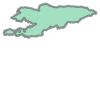

In [308]:
# Define input data
iso3 = "KGZ"
output_folder = f"/home/wb411133/projects/ProGreen_Suitability/Data/Output/{iso3}"
figures_folder = "../docs/images"
scaled_folder = os.path.join(output_folder, "scaled_data")

landcover_folder = os.path.join(output_folder, "WorldCover")
landcover_vrt = f'{landcover_folder}.vrt'
elevation_file = os.path.join(output_folder, "srtm_elevation.tif")
slope_file = os.path.join(output_folder, "srtm_slope.tif")
aspect_file = os.path.join(output_folder, "srtm_aspect.tif")
soil_file = os.path.join(output_folder, "soil_ph.tif")


for folder in [output_folder, landcover_folder, elevation_folder, scaled_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

global_bounds = gpd.read_file("/home/public/Data/GLOBAL/ADMIN/Admin0_Polys.shp")
inB = global_bounds.loc[global_bounds['ISO3'] == iso3].to_crs(4326)
inB.unary_union

In [12]:
# define source data location
### Slope, aspect, and elevation will be dynamically grabbed from the elevation library
terraclimate_precipitation = "/home/public/Data/GLOBAL/CLIMATE/TERRACLIMATE/TerraClimate_ppt_2022.nc"
terraclimate_evapotraspiration = "/home/public/Data/GLOBAL/CLIMATE/TERRACLIMATE/TerraClimate_pet_2022.nc"
soil_ph = '/home/public/Data/GLOBAL/LANDCOVER/SOIL/sol_ph.h2o_usda.4c1a2a_m_250m_b200..200cm_1950..2017_v0.2.tif'
soil_carbon = '/home/public/Data/GLOBAL/LANDCOVER/SOIL/sol_organic.carbon_usda.6a1c_m_250m_b200..200cm_1950..2017_v0.2.tif'

In [13]:
# Landcover data are available on an s3 bucket, details here https://registry.opendata.aws/esa-worldcover-vito/
if not os.path.exists(landcover_vrt):
    extent_obj = s3.get_object(Bucket="esa-worldcover", Key='v200/2021/esa_worldcover_grid.geojson')
    tile_extents = gpd.read_file(io.BytesIO(extent_obj['Body'].read()))
    sel_tiles = tile_extents.loc[tile_extents.intersects(inB.unary_union)]
    def get_tile(t_id):
        out_file = os.path.join(landcover_folder, f'{t_id}.tif')
        if not os.path.exists(out_file):
            s3.download_file('esa-worldcover', 
                            f'v200/2021/map/ESA_WorldCover_10m_2021_v200_{t_id}_Map.tif', 
                            out_file)
        return(out_file)

    local_tiles = sel_tiles['ll_tile'].apply(get_tile)

    vrt_options = gdal.BuildVRTOptions(resampleAlg='cubic', addAlpha=False)
    my_vrt = gdal.BuildVRT(landcover_vrt, list(local_tiles.values), options=vrt_options)
    my_vrt = None


# Extract and process the global datasets

1. Clip dataset to country extent
2. Apply exclusion
3. Apply suitability classification

In [246]:
precip = {'min_val':50,
          'max_val': None,
          'bad_vals': None,
          'classifier':'linear-ascending'}
precip_d, precip_profile = clip_and_classify(terraclimate_precipitation, inB, precip)
precip_d = np.sum(precip_d, axis=0) # get total precipitation across the months
precip_profile.update(count=1)

In [247]:
evapotranspiration = {'min_val':5,
                      'max_val': None,
                      'bad_vals': None,
                      'classifier':'linear-ascending'}
evapo_d, evapo_profile = clip_and_classify(terraclimate_evapotraspiration, inB, evapotranspiration)
evapo_d = np.sum(evapo_d, axis=0) # get total evapo-transpiration across the months
evapo_profile.update(count=1)

In [30]:
ph = {'min_val':8.3,
      'max_val': None,
      'bad_vals': None,
      'classifier':'linear-ascending'}
soil_d, soil_profile = clip_and_classify(soil_ph, inB, ph)
write_file(soil_d, soil_profile, soil_file)

In [35]:
carbon = {'min_val':0,
      'max_val': 60,
      'bad_vals': None,
      'classifier':'linear-descending'}
carbon_d, carbon_profile = clip_and_classify(soil_carbon, inB, carbon)

In [225]:
# Download and process elevation data
if not os.path.exists(elevation_file):
    elev_data, profile = stitch_dem(inB.total_bounds, dem_name='glo_90')
    elev_copy = np.reshape(elev_data, (1,elev_data.shape[0],elev_data.shape[1]))
    with rMisc.create_rasterio_inmemory(profile, elev_copy) as elevR:
        rMisc.standardizeInputRasters(elevR, rasterio.open(soil_file), inR1_outFile=elevation_file)
        
if not os.path.exists(slope_file):
    elev_scaled_r = rasterio.open(elevation_file)
    elev_scaled_data = elev_scaled_r.read()[0,:,:]
    elev_rd = richdem.rdarray(elev_scaled_data, no_data=profile['nodata'])
    slope_d = richdem.TerrainAttribute(elev_rd, attrib='slope_riserun')
    aspect_d = richdem.TerrainAttribute(elev_rd, attrib='aspect')
    with rasterio.open(slope_file, 'w', **elev_scaled_r.profile) as out_raster:
        out_raster.write_band(1, slope_d)
        
    with rasterio.open(aspect_file, 'w', **elev_scaled_r.profile) as out_raster:
        out_raster.write_band(1, aspect_d)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


In [97]:
elev = {'min_val':None,
      'max_val': 2250,
      'bad_vals': None,
      'classifier':'linear-ascending'}
#elev_d, elev_profile = clip_and_classify(elevation_file, inB, elev)
input_elev = rasterio.open(elevation_file).read()
elev_d = re_classify(input_elev, elev, None)

In [226]:
slope = {'min_val':None,
      'max_val': 45,
      'bad_vals': None,
      'classifier':'binary'}
#elev_d, elev_profile = clip_and_classify(elevation_file, inB, elev)
input_elev = rasterio.open(slope_file).read()
slope_d = re_classify(input_elev, slope, None)

In [113]:
aspect = {'min_val':None,
          'max_val':None,
          'ranges':           [(270-45), (270+45), 360], #Define range breaks
          'range_definition': [100,      0,       100],  #Assign values to ranges
          'classifier': 'ranges'}
# North is 270 degrees, so bad values are North +- 45 degrees
input_aspect = rasterio.open(aspect_file).read()
aspect_classified = re_classify(input_aspect, aspect, None)

In [287]:
landcover = {'min_val':None,
             'max_val':None,
             'map_vals':{10:50,  # Trees
                         20:100, # Shrubland
                         30:100, # Grassland
                         40:50,  # Crops
                         50:0,   # Built-up
                         60:100, # Bare
                         70:0,   # Snow and ice
                         80:0,   # Water
                         90:100, # Herbaceous wetland
                         95:100, # Mangroves
                         100:50, # Moss
                        },
            'classifier': 'convert'}

lc_d, lc_profile = clip_and_classify(landcover_vrt, inB, landcover)

In [298]:
# rasterize admin boundary to mask final result
output = rMisc.rasterizeDataFrame(inB, os.path.join(output_folder, "admin_bound.tif"), 
                                                 templateRaster=soil_file)
admin_d = output['vals']
admin_profile = output['meta']

# Scale all datasets to template dataset

In [299]:
templateR = rasterio.open(soil_file)
input_elev = rasterio.open(elevation_file)

defs = [
    [precip_d, precip_profile, os.path.join(scaled_folder, "precipitation.tif")],
    [evapo_d, evapo_profile, os.path.join(scaled_folder, "evapo_transpiration.tif")],
    [soil_d, soil_profile, os.path.join(scaled_folder, "soil_ph.tif")],
    [carbon_d, carbon_profile, os.path.join(scaled_folder, "soil_carbon.tif")],
    [elev_d, input_elev.profile, os.path.join(scaled_folder, "elevation.tif")],
    [slope_d, input_elev.profile, os.path.join(scaled_folder, "slope.tif")],
    [aspect_d, input_elev.profile, os.path.join(scaled_folder, "aspect.tif")],
    [lc_d, lc_profile, os.path.join(scaled_folder, "worldcover.tif")],
    [admin_d, admin_profile, os.path.join(scaled_folder, "admin_bounds.tif")]
]


In [300]:
importlib.reload(rMisc)

result = {}
for cdef in defs:
    label = os.path.basename(cdef[-1])[:-4:]
    if not os.path.exists(cdef[2]):
        cData, cProfile = scale_write(cdef[0], cdef[1], templateR, cdef[2])
    else:
        cur_r = rasterio.open(cdef[2])
        cData = cur_r.read()
        cProfile = cur_r.profile.copy()
    result[label] = cData
    print(label)

precipitation
evapo_transpiration
soil_ph
soil_carbon
elevation
slope
aspect
worldcover
admin_bounds


In [301]:
## TODO: in the combination, all the 0 values need to propagate as 0
## TODO: need to apply variable weighting

try:
    del final
    del final_good
except:
    pass

for key, value in result.items():
    print(f'{key}: {value.shape[0]}, {value.shape[2]}')
    good_mask = (value * 0) + 1
    good_mask[value == 0] = 0    
    try:        
        final = final + value
        final_good = final_good * good_mask
    except:
        final = value
        final_good = good_mask
        
final = (final - np.min(final)) / (np.max(final) - np.min(final)) * 100
final = final * final_good
final = final.astype(int)

precipitation: 1, 5182
evapo_transpiration: 1, 5182
soil_ph: 1, 5182
soil_carbon: 1, 5182
elevation: 1, 5182
slope: 1, 5182
aspect: 1, 5182
worldcover: 1, 5182
admin_bounds: 1, 5182


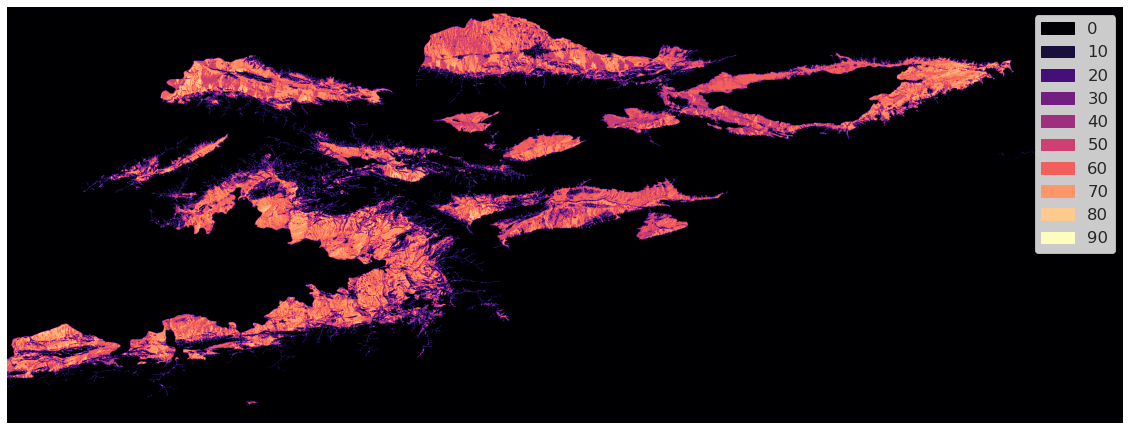

In [309]:
with rMisc.create_rasterio_inmemory(cProfile, final) as mapR:
    mapMisc.static_map_raster(mapR, thresh=list(range(0,100,10)), figsize=(20,20), 
                              out_file=os.path.join(figures_folder, "Suitability_beta.png"))

In [303]:
with rasterio.open(os.path.join(output_folder, "suitability.tif"), 'w', **templateR.profile) as out_raster:
    out_raster.write(final)

# DEBUGGING

In [285]:
# test re-classification of landcover
in_file = os.path.join(landcover_folder, "N42E069.tif")
out_file = os.path.join(output_folder, "N42E069.tif")

landcover = {'min_val':None,
             'max_val':None,
             'map_vals':{10:50,  # Trees
                         20:100, # Shrubland
                         30:100, # Grassland
                         40:50,  # Crops
                         50:0,   # Built-up
                         60:100, # Bare
                         70:0,   # Snow and ice
                         80:0,   # Water
                         90:100, # Herbaceous wetland
                         95:100, # Mangroves
                         100:50, # Moss
                        },
            'classifier': 'convert'}

temp_lc, temp_p = clip_and_classify(in_file, inB, landcover)

10 to 50
20 to 100
30 to 100
40 to 50
50 to 0
60 to 100
70 to 0
80 to 0
90 to 100
95 to 100
100 to 50


In [286]:
temp_lc

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0, 100, 100, ..., 100, 100, 100],
        [  0, 100, 100, ..., 100, 100, 100],
        ...,
        [  0, 100, 100, ...,  50,  50,  50],
        [  0, 100, 100, ...,  50,  50,  50],
        [  0, 100, 100, ...,  50,  50,  50]]])